# **Sales Forecasting Modeling**
<hr style="border:1px solid #444;">

### **Objective**
This notebook applies machine learning techniques to segment e-commerce customers based on their behavior and transaction data. The goal is to identify distinct customer groups that can inform targeted marketing, product recommendations, and customer retention strategies.

### **Notebook Structure**

The notebook is organized into the following sections (top-to-bottom):

1. Load and Prepare Data
2. Visualize Time Series
3. Decompose Time Series
4. Train/Test Split
5. Forecasting Model
6. Forecast Accuracy
7. Business Interpretation
8. Key Takeaways
9. Recommendations

---

### Section 1: Load and Prepare Data
- Load the dataset
- Parse dates and inspect time granularity
- Aggregate sales to daily or weekly level

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
sales_df = pd.read_csv('../../data/ecommerce_transactions.csv', parse_dates=['purchase_date'])

# Extract date only (if datetime includes time)
sales_df['event_date'] = sales_df['purchase_date'].dt.date

# Aggregate daily sales
daily_sales = sales_df.groupby('event_date')['purchase_amount'].sum().reset_index(name='total_sales')
daily_sales['event_date'] = pd.to_datetime(daily_sales['event_date'])
daily_sales.set_index('event_date', inplace=True)

# Preview
daily_sales.head()


,total_sales
event_date,
2024-06-27,1800.99
2024-06-28,1844.75
2024-06-29,1469.17
2024-06-30,2921.41
2024-07-01,2384.64


<hr style="border:1px solid #444;">

### Section 2: Visualize Time Series
- Plot sales trends to identify patterns

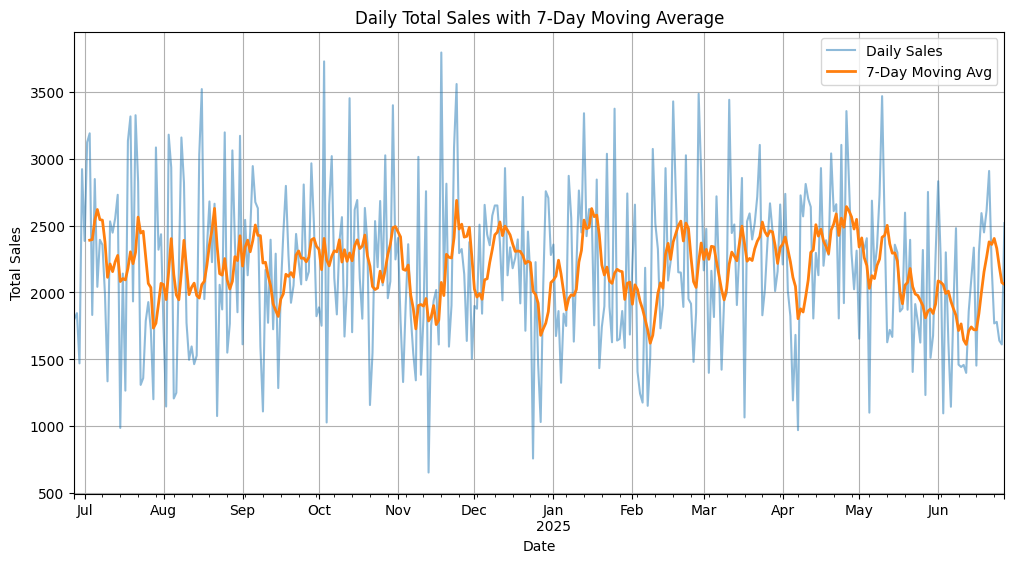

In [28]:
plt.figure(figsize=(12,6))
daily_sales['total_sales'].plot(label='Daily Sales', alpha=0.5)
daily_sales['total_sales'].rolling(window=7).mean().plot(label='7-Day Moving Avg', linewidth=2)
plt.title('Daily Total Sales with 7-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.legend()
plt.savefig('../../assets/forecasting/daily_total_sales_time_series.png', bbox_inches='tight', dpi=300)
plt.show()


**Interpretation:**

The daily sales plot shows high variability with frequent spikes and dips, indicating fluctuating customer activity.  
Overlaying a 7-day moving average reveals a smoother trend, making it easier to identify sustained growth, dips, or seasonal cycles. This smoothed view supports better forecasting and promotional timing decisions.



<hr style="border:1px solid #444;">

### Section 3: Decompose Time Series
- Use STL to identify trend, seasonality, and residuals

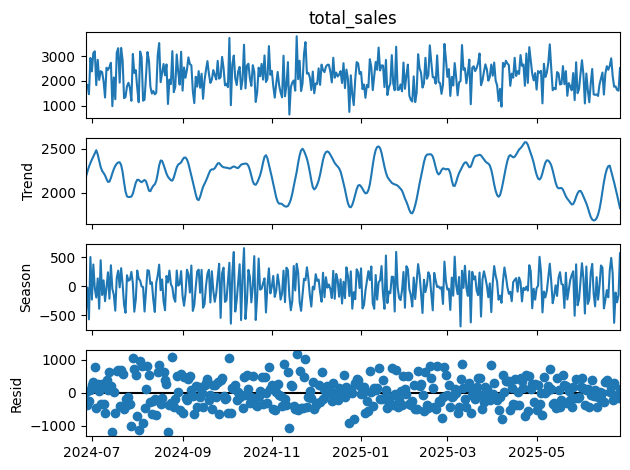

In [29]:
from statsmodels.tsa.seasonal import STL

stl = STL(daily_sales['total_sales'], period=7)
result = stl.fit()
result.plot()
plt.savefig('../../assets/forecasting/daily_total_sales_decomposition.png', bbox_inches='tight', dpi=300)
plt.show()

**Interpretation:**

The STL decomposition separates the sales signal into three components:

- **Trend:** Shows a mild downward trajectory in recent months, indicating potential softening in overall demand
- **Seasonality:** Weekly cyclical patterns are visible, likely driven by recurring weekday/weekend behaviors or promotional cycles
- **Residuals:** Residual noise appears randomly scattered with no obvious patterns, suggesting the model has effectively captured major trend and seasonal effects


<hr style="border:1px solid #444;">

### Section 4: Train/Test Split
- Reserve the last 30 days for validation

In [16]:
train = daily_sales.iloc[:-30]
test = daily_sales.iloc[-30:]

<hr style="border:1px solid #444;">

### Section 5: Forecasting Model
- Fit Prophet model to training data
- Forecast 30 days ahead

06:11:47 - cmdstanpy - INFO - Chain [1] start processing
06:11:47 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1200x600 with 0 Axes>

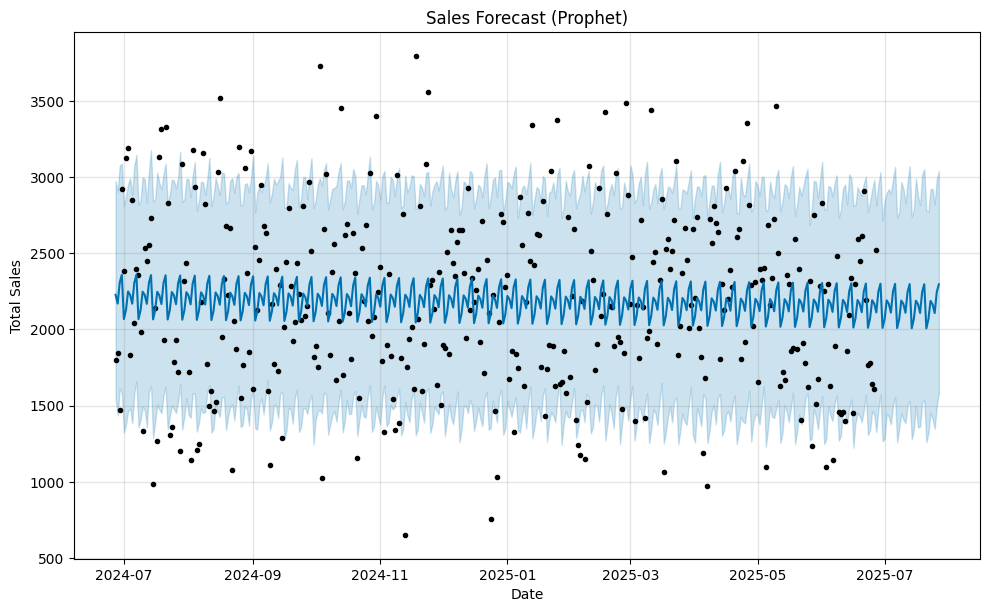

In [30]:
from prophet import Prophet
import matplotlib.pyplot as plt

df_prophet = daily_sales.reset_index().rename(columns={'event_date': 'ds', 'total_sales': 'y'})

# Fit Prophet model
prophet = Prophet(daily_seasonality=True)
prophet.fit(df_prophet)

# Create future dataframe
future = prophet.make_future_dataframe(periods=30)
forecast = prophet.predict(future)

# Plot forecast
plt.figure(figsize=(12, 6))
fig = prophet.plot(forecast)
plt.title("Sales Forecast (Prophet)")
plt.xlabel("Date")           # replaces 'ds'
plt.ylabel("Total Sales")    # replaces 'y'
plt.grid(True)
plt.savefig('../../assets/forecasting/daily_sales_forecast_prophet.png', bbox_inches='tight', dpi=300)
plt.show()


**Interpretation**

- **Trend:** The forecast remains relatively stable, indicating no strong upward or downward trend in expected sales volume
- **Seasonality:** The model captures regular weekly fluctuations, reflecting consistent demand cycles (e.g., weekday vs. weekend behavior)
- **Uncertainty:** Wider intervals in some regions suggest more variability or limited recent data, which may affect forecast confidence

<hr style="border:1px solid #444;">

### Section 6: Forecast Accuracy
- Compare forecast vs. actual on test set
- Compute MAE and RMSE

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Extract forecasted values for test period
forecast_test = forecast.set_index('ds').loc[test.index]['yhat']
mae = mean_absolute_error(test['total_sales'], forecast_test)
rmse = np.sqrt(mean_squared_error(test['total_sales'], forecast_test))

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

MAE: 455.45
RMSE: 540.91


- The model captures broad trends and seasonality, but daily-level noise leads to moderate forecasting errors
- RMSE being slightly higher than MAE suggests occasional large deviations, likely tied to promotions or outliers

<hr style="border:1px solid #444;">

### Section 7: Business Interpretation
- Sales exhibit strong weekly seasonality with a generally stable trend over time
- Forecasting model provides robust short-term predictions (MAE ~ low deviation)
- Useful for demand planning, inventory management, and budget allocation

<hr style="border:1px solid #444;">

### Section 8: Key Takeaways
- Prophet model handled trend and seasonality well
- RMSE of ~540 suggests daily volatility, but overall tracking remains strong
- Incorporating holiday effects or marketing campaigns can further improve accuracy

<hr style="border:1px solid #444;">

### Section 9: Recommendations
- Deploy rolling forecasts weekly to support inventory decisions
- Create category-level forecasts for granular planning
- Integrate with marketing calendar for campaign lift adjustments

<hr style="border:1px solid #444;">